In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Input
from pathlib import Path
import numpy as np

In [3]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=20, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing


In [4]:
download_dir = Path('/content/drive/MyDrive/Capston/PGAA_Capstone Project/CV/Dataset/House_dataset')

In [5]:
train_data_dir = download_dir/'Training'
valid_data_dir = download_dir/'Testing'
test_data_dir = download_dir/'Test'

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(valid_data_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 1754 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 579 images belonging to 1 classes.


In [6]:
def create_model(input_shape, n_classes, optimizer='adam', fine_tune=0):
    
  """  Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
  conv_base = VGG16(include_top=False,
                    weights='imagenet',
                    input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
  if fine_tune > 0:
    for layer in conv_base.layers[:-fine_tune]:
      layer.trainable = False
    
  else:
    for layer in conv_base.layers:
      layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
  top_model = conv_base.output
  top_model = Flatten(name = 'flatten')(top_model)
  top_model = Dense(4096, activation='relu')(top_model)
  top_model = Dense(1072, activation='relu')(top_model)
  top_model = Dropout(0.2)(top_model)
  output_layer = Dense(n_classes, activation='sigmoid')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
  model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
  return model

In [7]:
pip install livelossplot

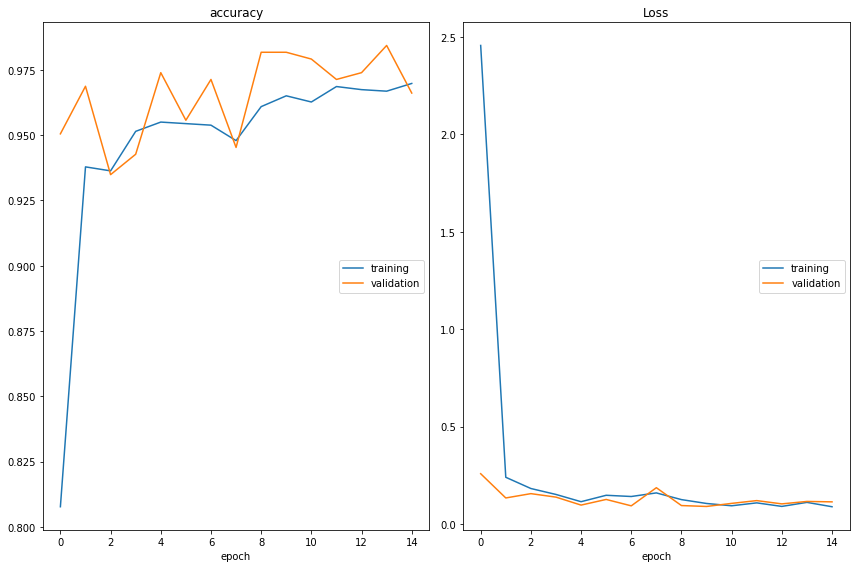

accuracy
	training         	 (min:    0.808, max:    0.970, cur:    0.970)
	validation       	 (min:    0.935, max:    0.984, cur:    0.966)
Loss
	training         	 (min:    0.088, max:    2.457, cur:    0.088)
	validation       	 (min:    0.090, max:    0.258, cur:    0.114)
27/27 [==============================] - 84s 3s/step - loss: 0.0885 - accuracy: 0.9698 - val_loss: 0.1135 - val_accuracy: 0.9661


In [8]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

input_shape = (224, 224, 3)
optim_2 = Adam(learning_rate=0.0001)
n_classes=1

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 25

# Train the model with Fine-tuning 1.
vgg_model1 = create_model(input_shape, n_classes, optim_2, fine_tune=2)

vgg_history1 = vgg_model1.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [9]:
vgg_model1.load_weights('tl_model_v1.weights.best.hdf5')

In [10]:
import pandas as pd
validgen.reset
ytesthat = vgg_model1.predict_generator(validgen)
df = pd.DataFrame({
    'filename':validgen.filenames,
    'predict':ytesthat[:,0],
    'y':validgen.classes
})

pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)
df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


,filename,predict,y,y_pred
0,House/house (1).jpeg,1.00000,0,1
1,House/house (1).jpg,0.00026,0,0
2,House/house (1).png,0.00244,0,0
3,House/house (10).jpg,0.00365,0,0
4,House/house (10).png,1.00000,0,1
5,House/house (100).jpg,0.01009,0,0
6,House/house (101).jpg,1.00000,0,1
7,House/house (102).jpg,0.00002,0,0
8,House/house (103).jpg,1.00000,0,1
9,House/house (104).jpg,0.67319,0,1


In [11]:
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 400 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 400 Validation images : 209


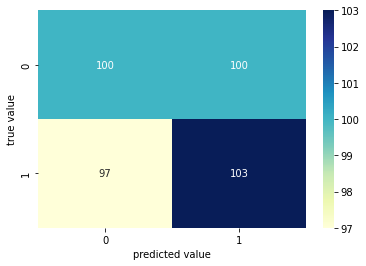

In [11]:
#Prediction of test set
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

In [17]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.68
df.y_pred = df.y_pred.astype(int)
df.head(10)

,filename,predict,y,y_pred
0,House/house (1).jpeg,1.00000,0,1
1,House/house (1).jpg,0.00026,0,0
2,House/house (1).png,0.00244,0,0
3,House/house (10).jpg,0.00365,0,0
4,House/house (10).png,1.00000,0,1
5,House/house (100).jpg,0.01009,0,0
6,House/house (101).jpg,1.00000,0,1
7,House/house (102).jpg,0.00002,0,0
8,House/house (103).jpg,1.00000,0,1
9,House/house (104).jpg,0.67319,0,0


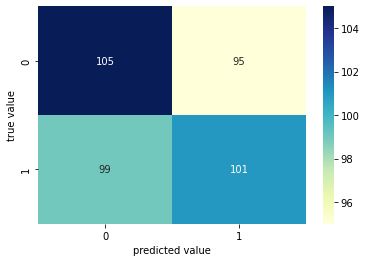

In [18]:
conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

In [38]:
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 400 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 400 Validation images : 194


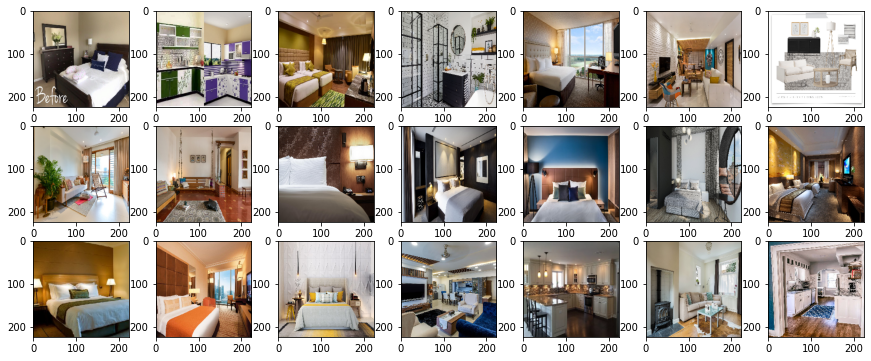

In [19]:
#Some of House image misclassified as Not House.
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

HouseasNot = df['filename'][(df.y==0)&(df.y_pred==1)]
fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 3
for i in range(columns*rows):
    #img = mpimg.imread()
    img = image.load_img('/content/drive/MyDrive/Capston/PGAA_Capstone Project/CV/Dataset/House_dataset/Testing/'+HouseasNot.iloc[i], target_size=(224, 224))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)

plt.show()

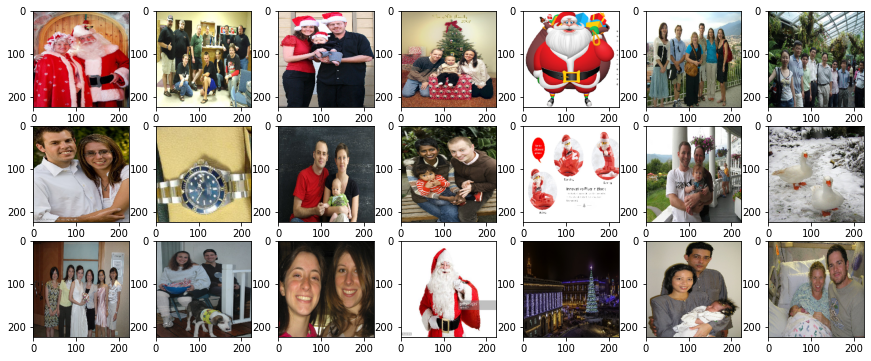

In [20]:
#Some of Not House image misclassified as House.
import matplotlib.image as mpimg

NotasHouse = df['filename'][(df.y==1)&(df.y_pred==0)]
fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 3
for i in range(columns*rows):
    #img = mpimg.imread()
    img = image.load_img('/content/drive/MyDrive/Capston/PGAA_Capstone Project/CV/Dataset/House_dataset/Testing/'+NotasHouse.iloc[i], target_size=(224, 224))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

---

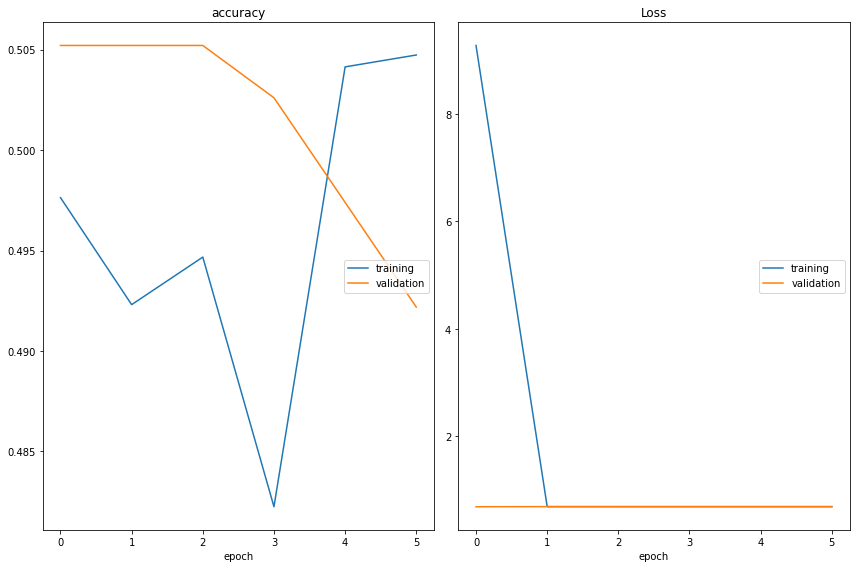

accuracy
	training         	 (min:    0.482, max:    0.505, cur:    0.505)
	validation       	 (min:    0.492, max:    0.505, cur:    0.492)
Loss
	training         	 (min:    0.693, max:    9.275, cur:    0.693)
	validation       	 (min:    0.691, max:    0.693, cur:    0.693)
27/27 [==============================] - 87s 3s/step - loss: 0.6931 - accuracy: 0.5047 - val_loss: 0.6932 - val_accuracy: 0.4922


In [21]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

plot_loss = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
checkpoint = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf6',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop1 = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')


input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=1

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 25

# Train the model with Fine-tuning 3.
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=3)

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[checkpoint, early_stop1, plot_loss],
                            verbose=1)

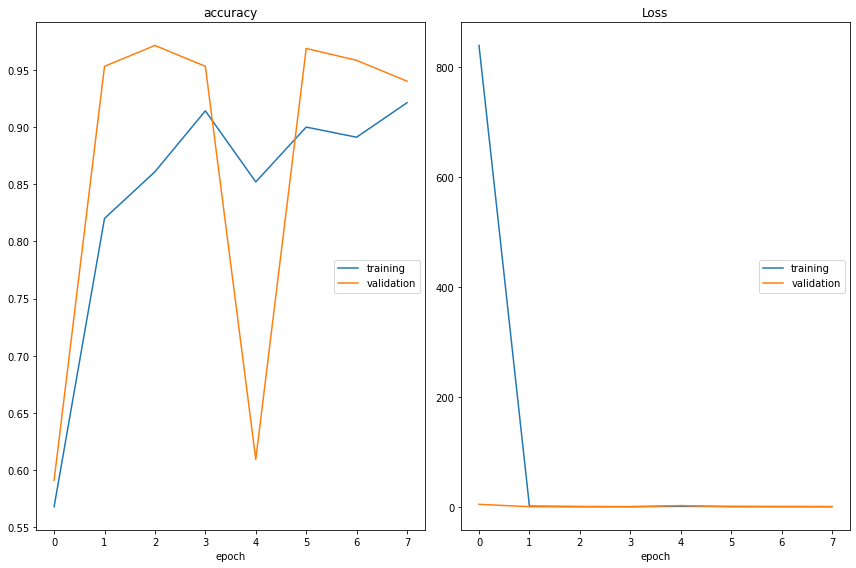

accuracy
	training         	 (min:    0.568, max:    0.921, cur:    0.921)
	validation       	 (min:    0.591, max:    0.971, cur:    0.940)
Loss
	training         	 (min:    0.292, max:  839.913, cur:    0.321)
	validation       	 (min:    0.120, max:    4.501, cur:    0.161)
27/27 [==============================] - 87s 3s/step - loss: 0.3215 - accuracy: 0.9213 - val_loss: 0.1609 - val_accuracy: 0.9401


In [23]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

plot_loss_02 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
t2_checkpoint = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf7',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop_02 = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

# Use a smaller learning rate
input_shape = (224,224,3)
n_classes = 1
optim_3 = 'RMSprop'

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 25

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model3 = create_model(input_shape, n_classes, optim_3, fine_tune=2)

vgg_fthist = vgg_model3.fit(
    traingen,
    batch_size=BATCH_SIZE,
    validation_data=validgen,
    steps_per_epoch=n_steps, 
    validation_steps=n_val_steps,
    epochs=n_epochs,
    callbacks=[t2_checkpoint, early_stop_02, plot_loss_02],
    verbose=1
)

In [24]:
vgg_model3.load_weights('tl_model_v1.weights.best.hdf7')

In [ ]:
validgen.reset

y_test = vgg_model3.predict_generator(validgen)
df01 = pd.DataFrame({
    'filename' : validgen.filenames,
    'predict' : y_test[:,0]
    'y' : validgen.classes
})

pd.set_option('display.float_format', lambda x: '%.5f' % x)
df01['y_pred'] = df01['predict'] > 0.5
df01.y_pred = df01.y_pred.astype(int)


In [ ]:
misclassified = df01[df01['y']!=df01['y_pred']]
print('Total misclassified image from 400 Validation images : %d'%misclassified['y'].count())

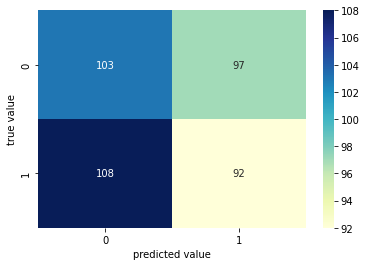

In [27]:
conf_matrix = confusion_matrix(df01.y,df01.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

In [ ]:
import pandas as pd
testgen.reset
y_test_p = vgg_model1.predict(testgen)


In [40]:
df_p = pd.DataFrame({
    'filename':testgen.filenames,
    'predict':y_test_p[:,0]
})

pd.set_option('display.float_format', lambda x: '%.4f' % x)
df_p['y_pred'] = df_p['predict']>0.68
df_p.y_pred = df_p.y_pred.astype(int)
df_p.head()

,filename,predict,y_pred
0,New Folder With Items/Image (1).jpeg,0.0012,0
1,New Folder With Items/Image (1).jpg,0.0000,0
2,New Folder With Items/Image (1).png,0.0000,0
3,New Folder With Items/Image (10).jpeg,0.0000,0
4,New Folder With Items/Image (10).jpg,0.0000,0


In [41]:
df_p["y_pred"].replace({0: "House", 1: "Not_House"}, inplace=True)
df_p.head()

,filename,predict,y_pred
0,New Folder With Items/Image (1).jpeg,0.0012,House
1,New Folder With Items/Image (1).jpg,0.0000,House
2,New Folder With Items/Image (1).png,0.0000,House
3,New Folder With Items/Image (10).jpeg,0.0000,House
4,New Folder With Items/Image (10).jpg,0.0000,House


In [ ]:
df_p= df_p.drop('predict', axis=1)


In [44]:
df_p.loc[df_p['filename'].str.split('/').str.len() == 2, 'name'] = df_p['filename'].str.split('/').str[-1]
df_p

,filename,y_pred,name
0,New Folder With Items/Image (1).jpeg,House,Image (1).jpeg
1,New Folder With Items/Image (1).jpg,House,Image (1).jpg
2,New Folder With Items/Image (1).png,House,Image (1).png
3,New Folder With Items/Image (10).jpeg,House,Image (10).jpeg
4,New Folder With Items/Image (10).jpg,House,Image (10).jpg
...,...,...,...
574,New Folder With Items/Image (95).jpg,House,Image (95).jpg
575,New Folder With Items/Image (96).jpg,House,Image (96).jpg
576,New Folder With Items/Image (97).jpg,Not_House,Image (97).jpg
577,New Folder With Items/Image (98).jpg,House,Image (98).jpg


In [46]:
df_p.drop('filename', axis=1, inplace=True)
df_p = df_p[['name', 'y_pred']]
df_p.head()

,name,y_pred
0,Image (1).jpeg,House
1,Image (1).jpg,House
2,Image (1).png,House
3,Image (10).jpeg,House
4,Image (10).jpg,House


In [47]:
%%capture
# Model Accuracy
x1 = vgg_model1.evaluate_generator(traingen)
x2 = vgg_model1.evaluate_generator(validgen)

In [50]:
print('Training Accuracy  : %1.2f%%     Training loss  : %1.6f'%(x1[1]*100,x1[0]))
print('Validation Accuracy: %1.2f%%     Validation loss: %1.6f'%(x2[1]*100,x2[0]))

Training Accuracy  : 95.90%     Training loss  : 0.105314
Validation Accuracy: 98.25%     Validation loss: 0.078039


In [48]:
df_p.to_csv('/content/drive/MyDrive/Capston/PGAA_Capstone Project/CV/Dataset/House_dataset/prediction01.csv', header=False)

In [49]:
vgg_model1.save('/content/drive/MyDrive/Capston/PGAA_Capstone Project/CV/Dataset/House_dataset/vgg_model1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capston/PGAA_Capstone Project/CV/Dataset/House_dataset/vgg_model1/assets


##Conclusion
The Architecture and parameter used in this network are capable of producing accuracy of 98.25% on Validation Data which is pretty good. It is possible to Achieve more accuracy on this dataset using deeper network and fine tuning of network parameters for training. You can download this trained model from resource directory and Play with it.